In [1]:
# import libraries
import numpy as np
import pandas as pd
import dionysus as d
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import re

%matplotlib widget

In [2]:
# define the classes
class Point:
    id: int
    coord: np.ndarray
    dominant: int
    value: float
    values: list[float]
    tissue: bool
    valid: bool

point_list: list[Point] = []
edge_set: set[tuple[int]] = set()
triangle_set: set[tuple[int]] = set()
tetrahedron_set: set[tuple[int]] = set()


In [3]:
# load from st data files
# points_data = pd.read_csv("assets/HT112C1-points.csv")
# tets_data = pd.read_csv("assets/HT112C1-tets.csv")

# load from toy data files
# points_data = pd.read_csv("assets/torus-points.csv")
# tets_data = pd.read_csv("assets/torus-tets.csv")

points_data = pd.read_csv("assets/small-torus/points.csv", header=None)
tets_data = pd.read_csv("assets/small-torus/tets.csv", header=None)

In [4]:
coords = points_data.iloc[:, :3]
x_limits = coords.iloc[:, 0].agg(["min", "max"]).tolist()
y_limits = coords.iloc[:, 1].agg(["min", "max"]).tolist()
z_limits = coords.iloc[:, 2].agg(["min", "max"]).tolist()

x_range = abs(x_limits[1] - x_limits[0])
x_middle = (x_limits[0] + x_limits[1]) / 2
y_range = abs(y_limits[1] - y_limits[0])
y_middle = (y_limits[0] + y_limits[1]) / 2
z_range = abs(z_limits[1] - z_limits[0])
z_middle = (z_limits[0] + z_limits[1]) / 2

plot_radius = 0.5 * max([x_range, y_range, z_range])

# plot the point cloud
# fig = plt.figure()
# ax = fig.add_subplot(111, projection="3d")
# ax.scatter(points_data.iloc[:, 0].to_numpy(), points_data.iloc[:, 1].to_numpy(), points_data.iloc[:, 2].to_numpy())
# ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
# ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
# ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
# plt.show()

In [5]:
# FIXME: slow process

num_materials = points_data.shape[1] - 3

for i, row in points_data.iterrows():
    point = Point()
    point.id = i
    point.coord = row.iloc[:3]
    values = row.iloc[3:]
    point.dominant = np.argmax(values)
    values_sorted = sorted(values)
    # point.values = [v - values_sorted[-2] for v in values]
    point.values = values.to_list()
    point.value = values_sorted[-1] - values_sorted[-2]
    point.tissue = point.dominant != num_materials - 1
    point.valid = not pd.isna(point.value) and point.tissue
    point_list.append(point)

edge_combinations = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
triangle_combinations = [
    (0, 1, 2),
    (0, 1, 3),
    (0, 2, 3),
    (1, 2, 3),
]


def same_material(point_indices):
    return all([point_list[point].dominant == point_list[point_indices[0]].dominant for point in point_indices])


def all_valid(point_indices):
    return all([point_list[point].valid for point in point_indices])


# TODO: use hash table for faster lookup
# FIXME: point list not getting all points 
for i, tet in tets_data.iterrows():
    edges = [sorted([tet.iloc[combination[0]], tet.iloc[combination[1]]]) for combination in edge_combinations]
    [edge_set.add(tuple(x)) for x in edges if all_valid(x)]
    triangles = [
        sorted([tet.iloc[combination[0]], tet.iloc[combination[1]], tet.iloc[combination[2]]]) for combination in triangle_combinations
    ]
    [triangle_set.add(tuple(x)) for x in triangles if all_valid(x)]
    if all_valid(tet):
        tetrahedron_set.add(tuple(sorted(tet)))

Material 0 has 14812 points, 92841 edges, 150930 triangles, 72900 tets, 331483 simplices in total
Material 0 dimension 0 has 23 finite points and 1 infinite points


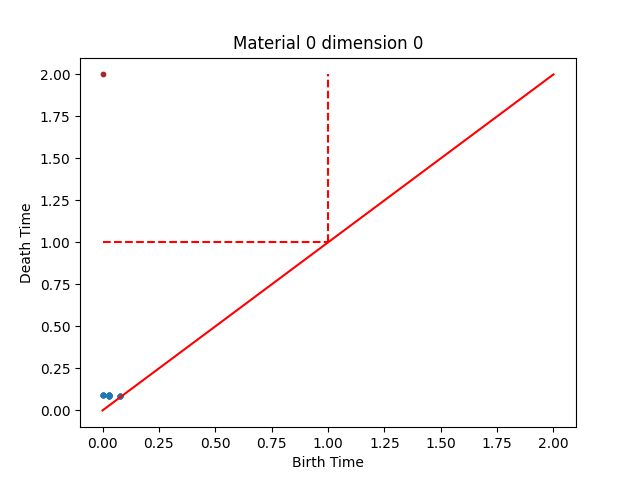

Material 0 dimension 1 has 1 finite points and 0 infinite points


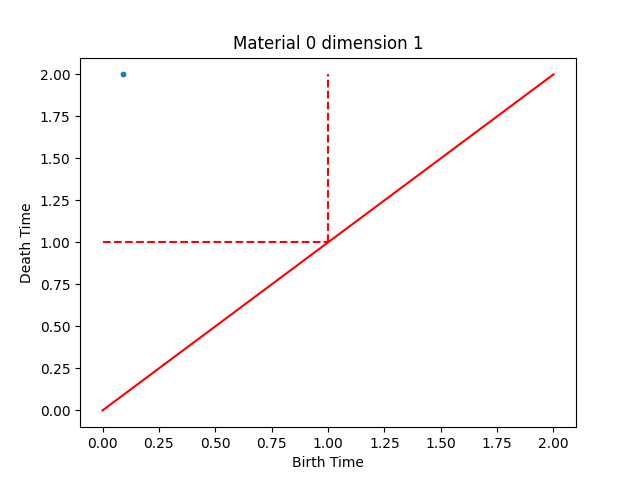

Material 0 dimension 2 has 0 finite points and 0 infinite points


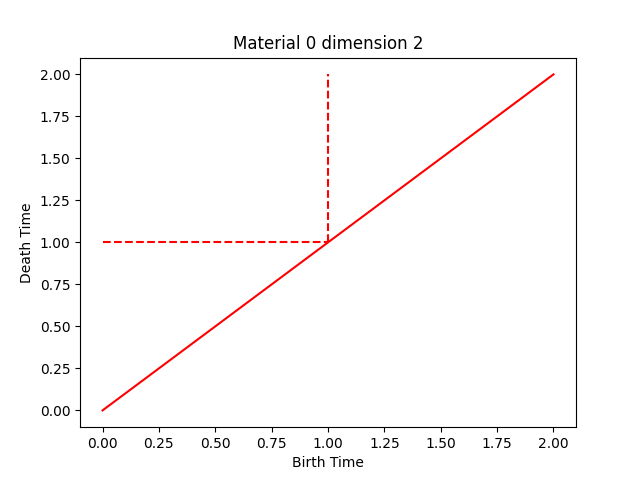

Material 0 dimension 3 has 0 finite points and 0 infinite points


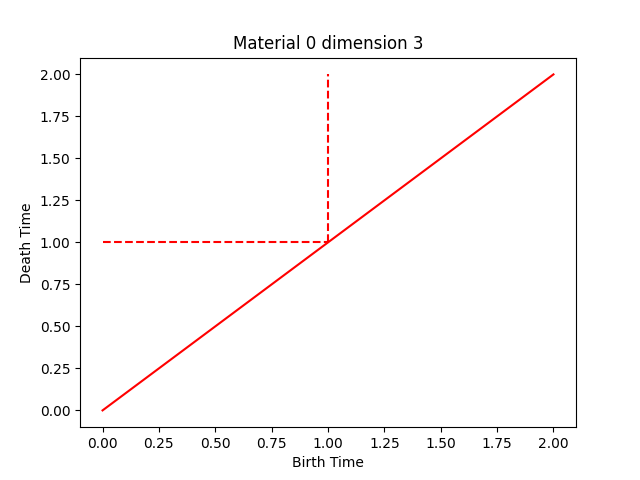

Material 0 has 14812 points and 150930 faces


In [6]:
generator_indices_by_material_and_dimension = [[] for _ in range(num_materials)]
filtrations_by_material = [[] for _ in range(num_materials)]
ph_matrix_by_material = [[] for _ in range(num_materials)]
diagrams_by_material = [[] for _ in range(num_materials)]

point_index_filtered = [None for _ in range(len(point_list))]
count = 0
for i, point in enumerate(point_list):
    if point.valid:
        point_index_filtered[i] = count
        count += 1


# iterate through the materials
for material in range(1):
    # if len(points_by_material[material]) == 0:
    #     print(f"Material {material} has no points")
    #     continue

    points = [([point.id], 1 - point.values[material]) for point in point_list if point.valid]
    edges = [(list(edge), 1 - min([point_list[point].values[material] for point in edge])) for edge in edge_set]
    triangles = [(list(triangle), 1 - min([point_list[point].values[material] for point in triangle])) for triangle in triangle_set]
    tets = [(list(tet), 1 - min([point_list[point].values[material] for point in tet])) for tet in tetrahedron_set]

    simplices = []
    simplices.extend(points)
    simplices.extend(edges)
    simplices.extend(triangles)
    simplices.extend(tets)

    print(f"Material {material} has {len(points)} points, {len(edges)} edges, {len(triangles)} triangles, {len(tets)} tets, {len(simplices)} simplices in total")

    filtration = d.Filtration()
    for vertices, time in simplices:
        filtration.append(d.Simplex(vertices, time))
    filtration.sort()

    ph_matrix = d.homology_persistence(filtration, method="column")
    diagrams = d.init_diagrams(ph_matrix, filtration)

    for i, diagram in enumerate(diagrams):
        plt.figure()
        plt.title(f"Material {material} dimension {i}")
        filtered_diagram = [pt for pt in diagram if pt.birth < pt.death]

        # filter points that live forever
        finite_birth_times = [pt.birth for pt in filtered_diagram if pt.death != float("inf")]
        finite_death_times = [pt.death for pt in filtered_diagram if pt.death != float("inf")]
        infinite_birth_times = [pt.birth for pt in filtered_diagram if pt.death == float("inf")]
        infinite_death_times = [2.0 for pt in filtered_diagram if pt.death == float("inf")]

        print(
            f"Material {material} dimension {i} has {len(finite_birth_times)} finite points and {len(infinite_birth_times)} infinite points"
        )

        # plot using plt.scatter instead
        plt.scatter(finite_birth_times, finite_death_times, s=10)
        plt.scatter(infinite_birth_times, infinite_death_times, s=10, color="brown")
        plt.plot([0, 2], [0, 2], "r")
        plt.plot([1, 1], [1, 2], "r--")
        plt.plot([0, 1], [1, 1], "r--")
        plt.xlabel("Birth Time")
        plt.ylabel("Death Time")
        plt.show()

    
    vertices = [list(point_list[point[0][0]].coord) for point in points]
    intensities = [point[1] for point in points]
    faces = [[point_index_filtered[v] for v in triangle[0]] for triangle in triangles]

    if len(faces) == 0: 
        print(f"Material {material} has {len(vertices)} but no faces")
        continue
    else:
        print(f"Material {material} has {len(vertices)} points and {len(faces)} faces")

    x, y, z = zip(*vertices)
    i, j, k = zip(*faces)

    fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, intensity=intensities, colorscale=[[0, 'navy'], [0.25, 'cyan'], [0.5, 'lime'], [0.75, 'yellow'], [1, 'red']], opacity=0.50)])

    # generator_vertices = generator_indices_by_material_and_dimension[material][0]
    # generator_vertices_coord = [list(point_list[point].coord) for point in generator_vertices]
    # if len(generator_vertices) == 0:
    #     print(f"Material {material} has no generators")
    # else:
    #     g_x, g_y, g_z = zip(*generator_vertices_coord)
    #     fig.add_trace(go.Scatter3d(x=g_x, y=g_y, z=g_z, mode="markers", marker=dict(size=5, color="black", opacity=0.8)))

    fig.update_layout(scene=dict(
        xaxis=dict(range=[x_middle - plot_radius, x_middle + plot_radius]),
        yaxis=dict(range=[y_middle - plot_radius, y_middle + plot_radius]),
        zaxis=dict(range=[z_middle - plot_radius, z_middle + plot_radius]),
        aspectmode='manual'),
        title_text=f"Material {material}"
    )
    fig.show()

    filtrations_by_material[material] = filtration
    ph_matrix_by_material[material] = ph_matrix
    diagrams_by_material[material] = diagrams

In [24]:

filtration = filtrations_by_material[0]
ph_matrix = ph_matrix_by_material[0]
diagrams = diagrams_by_material[0]

pairs = {}
generator_columns_by_dimension = [[] for _ in range(4)]

for j in range(len(ph_matrix)):
    if ph_matrix.pair(j) != ph_matrix.unpaired:
        pairs[ph_matrix.pair(j)] = j

    if ph_matrix.pair(j) < j or ph_matrix.pair(j) == ph_matrix.unpaired:
        continue

    if filtration[j].data < filtration[ph_matrix.pair(j)].data:
        generator_columns_by_dimension[filtration[j].dimension()].append(filtration[j][0])
        # print(j, ph_matrix[j])

# print(generator_columns_by_dimension)
# print([filtration[i][0] for i in generator_columns_by_dimension[1]])

def get_pairs_col(index): 
    if index != None:
        return ph_matrix[index]

# for diagram in diagrams:
#     for point in diagram: 
#         print(point.data, ph_matrix[point.data], filtration[point.data].dimension(), pairs.get(point.data), ph_matrix[pairs.get(point.data)] if pairs.get(point.data) != None else None)

# print(ph_matrix[260647])


numbers_after_asterisk = [int(num) for num in re.findall(r'\*(\d+)', str(ph_matrix[260647]))]
loop_edges = []
# print(numbers_after_asterisk)
for i, n in enumerate(numbers_after_asterisk):
    loop_edges.append([filtration[n][0], filtration[n][1]])
    print(filtration[n][0], filtration[n][1])



14037 14038
14043 14044
14125 14170
14138 14184
14395 14440
14414 14460
14622 14668
14642 14687
14898 14944
14912 14957
15038 15039
15044 15045
14038 14039
14042 14043
14170 14215
14184 14230
14350 14395
14368 14414
14668 14714
14687 14732
14852 14898
14867 14912
15039 15040
15043 15044
13995 13996
13996 14042
14230 14231
14231 14277
14259 14304
14277 14323
14304 14350
14323 14368
14714 14759
14759 14805
14805 14851
14851 14852
15040 15086
15043 15088
15086 15087
15087 15088
13995 14040
14037 14082
14039 14040
14044 14090
14081 14082
14081 14126
14090 14091
14091 14137
14125 14126
14137 14138
14215 14260
14259 14260
14440 14486
14460 14505
14486 14531
14505 14551
14531 14577
14551 14596
14577 14622
14596 14642
14732 14777
14777 14822
14822 14867
14944 14945
14945 14991
14956 14957
14956 15001
14991 14992
14992 15038
15000 15001
15000 15045


In [25]:

def build_adjacency_list(edges):
    adjacency_list = {}
    for edge in edges:
        u, v = edge
        if u not in adjacency_list:
            adjacency_list[u] = []
        if v not in adjacency_list:
            adjacency_list[v] = []
        adjacency_list[u].append(v)
        adjacency_list[v].append(u)
    return adjacency_list

def has_cycle_dfs(v, visited, parent, adjacency_list):
    visited[v] = True
    for neighbor in adjacency_list[v]:
        if not visited[neighbor]:
            if has_cycle_dfs(neighbor, visited, v, adjacency_list):
                return True
        elif neighbor != parent:
            return True
    return False

def detect_cycle(loop_edges):
    adjacency_list = build_adjacency_list(loop_edges)
    visited = {vertex: False for vertex in adjacency_list}
    
    for vertex in adjacency_list:
        if not visited[vertex]:
            if has_cycle_dfs(vertex, visited, -1, adjacency_list):
                return True
    return False

if detect_cycle(loop_edges):
    print("The edges form a loop.")
else:
    print("The edges do not form a loop.")

The edges form a loop.
